Name: Tien-Ching Hsieh  
Github Username: hsieh2000  
USC ID: 2642366337  

### 1.(a)  
Datasets are stored under the path "data/AReM".

### 1.(b)

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import bootstrap
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import statsmodels.api as sm
from sklearn.utils import resample
import warnings

warnings.filterwarnings("ignore")



In [2]:
df_training = pd.DataFrame()
df_testing = pd.DataFrame()

folder_lst = os.listdir("../data/AReM")
# print(folder_lst)
for folder in folder_lst:
    if ".pdf" in folder or ".DS_Store" in folder:
        pass

    else:
        concat_path = f"../data/AReM/{folder}"
        data_files = os.listdir(concat_path)
        if folder == 'bending1' or folder == 'bending2':
            for file in data_files:
                second_concat_path = f"{concat_path}/{file}"

                # handling wrong format data (using space as )
                if second_concat_path == "../data/AReM/bending2/dataset4.csv":
                    cols = _df.columns
                    with open("../data/AReM/bending2/dataset4.csv", "r") as f:
                        rows = f.readlines()
                    _df = pd.read_csv(StringIO("".join(rows[5:]).replace(" \n", "\n").replace(" ", ",")), header=None)
                    _df.rename(columns= {i:j for i, j in enumerate(cols)}, inplace=True)
                else:
                    _df = pd.read_csv(second_concat_path, usecols=range(7), skiprows=4,)
                    
                _df["label"] = f"{folder}"

                if file == 'dataset1.csv' or file == 'dataset2.csv':
                    df_testing = pd.concat([df_testing, _df],ignore_index = True)

                else:
                    df_training = pd.concat([df_training, _df], ignore_index = True)
        else:
            for file in data_files:
                second_concat_path = f"{concat_path}/{file}"
                _df = pd.read_csv(second_concat_path, usecols=range(7), skiprows=4,)
                _df["label"] = f"{folder}"

                if file == 'dataset1.csv' or file == 'dataset2.csv' or file == 'dataset3.csv':
                    df_testing = pd.concat([df_testing, _df], ignore_index = True)

                else:
                    df_training = pd.concat([df_training, _df], ignore_index = True)

df_training.rename(columns={"# Columns: time": "time"}, inplace=True)
df_testing.rename(columns={"# Columns: time": "time"}, inplace=True)

print(df_training.head())
print("\n"+"-"*50+"\n")
print(df_testing.head())




   time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0     0      42.00       0.00      18.50       0.50      12.00       0.00   
1   250      42.00       0.00      18.00       0.00      11.33       0.94   
2   500      42.75       0.43      16.75       1.79      18.25       0.43   
3   750      42.50       0.50      16.75       0.83      19.00       1.22   
4  1000      43.00       0.82      16.25       0.83      18.00       0.00   

      label  
0  bending1  
1  bending1  
2  bending1  
3  bending1  
4  bending1  

--------------------------------------------------

   time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0     0      39.25       0.43      22.75       0.43      33.75        1.3   
1   250      39.25       0.43      23.00       0.00      33.00        0.0   
2   500      39.25       0.43      23.25       0.43      33.00        0.0   
3   750      39.50       0.50      23.00       0.71      33.00        0.0   
4  1000      39

In [3]:
print(df_training.info())
print("\n"+"-"*50+"\n")
print(df_testing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33119 entries, 0 to 33118
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       33119 non-null  int64  
 1   avg_rss12  33119 non-null  float64
 2   var_rss12  33119 non-null  float64
 3   avg_rss13  33119 non-null  float64
 4   var_rss13  33119 non-null  float64
 5   avg_rss23  33119 non-null  float64
 6   var_rss23  33119 non-null  float64
 7   label      33119 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB
None

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       9120 non-null   int64  
 1   avg_rss12  9120 non-null   float64
 2   var_rss12  9120 non-null   float64
 3   avg_rss13  9120 non-null   float64
 4   var_rss13  9120 non-n

### 1.(c)  
#### i

- Minimum: Represents the minimum time series data within a window.  
- Maximum: Represents the maximum time series data within a window.  
- Mean: The average of time series data over a window.  
- Median: The middle value once time series data are arranged in order, which is also the second quartile.  
- First quartile - The value of 25th percentile of time series data.
- Third quartile - The value of 75th percentile of time series data.
- Interquartile Range - The gap between 75th and 25th percentiles of time series data.
- Variance: The dispersion of numbers from the mean.  
- Standard deviation: The square root of variance.  
- Range: The difference between the maximum and minimum.  
- Skewness: The measure of symmetry, or more precisely, the lack of symmetry.  
- Kurtosis: The measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 


#### ii

In [4]:
folder_lst = os.listdir("../data/AReM")
arr = []
n = 0
for folder in folder_lst:
    if ".pdf" in folder or ".DS_Store" in folder:
        pass
    else:
        concat_path = f"../data/AReM/{folder}"
        data_files = os.listdir(concat_path)
        for file in data_files:
            second_concat_path = f"{concat_path}/{file}"
            if second_concat_path == "../data/AReM/bending2/dataset4.csv":
                with open("../data/AReM/bending2/dataset4.csv", "r") as f:
                    rows = f.readlines()
                _df = pd.read_csv(StringIO("".join(rows[5:]).replace(" \n", "\n").replace(" ", ",")), header=None)
                _df.rename(columns= {i:j for i, j in enumerate(df_training.columns)}, inplace=True)
                _df.rename(columns={"# Columns: time": "time"}, inplace=True)

            else:
                _df = pd.read_csv(second_concat_path, usecols=range(7), skiprows=4,)
                _df.rename(columns={"# Columns: time": "time"}, inplace=True)

            # print(second_concat_path)
            _arr = _df.describe().iloc[1:, 1:].to_numpy()

            # print(_arr[2, :]) #min
            # print(_arr[6, :]) #max
            # print(_arr[0, :]) #mean
            # print(_arr[4, :]) #median
            # print(_arr[1, :]) #std
            # print(_arr[3, :]) #1st
            # print(_arr[5, :]) #3rd 
            _arr_parallel_concat = np.stack((_arr[2, :], _arr[6, :], _arr[0, :], _arr[4, :], _arr[1, :], _arr[3, :], _arr[5, :]), axis = 1)
            _arr_parallel_concat = _arr_parallel_concat.reshape(-1, 42)
            arr.append(_arr_parallel_concat.tolist()[0])

cols = []
for i in range(6):
    for col in ["min", "max", "mean", "median", "standard deviation", "1st quart", "3rd quart",]:
        cols.append(f"{col}{i+1}")

df_tdf = pd.DataFrame(arr, columns=cols)
df_tdf

,min1,max1,mean1,median1,standard deviation1,1st quart1,3rd quart1,min2,max2,mean2,...,standard deviation5,1st quart5,3rd quart5,min6,max6,mean6,median6,standard deviation6,1st quart6,3rd quart6
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


#### iii

In [5]:
df_tdf.describe().loc["std", :]


min1                   9.569975
max1                   4.394362
mean1                  5.335718
median1                5.440054
standard deviation1    1.772153
1st quart1             6.153590
3rd quart1             5.138925
min2                   0.000000
max2                   5.062729
mean2                  1.574164
median2                1.412244
standard deviation2    0.884105
1st quart2             0.946386
3rd quart2             2.125266
min3                   2.956462
max3                   4.875137
mean3                  4.008380
median3                4.036396
standard deviation3    0.946710
1st quart3             4.220658
3rd quart3             4.171628
min4                   0.000000
max4                   2.183625
mean4                  1.166114
median4                1.145586
standard deviation4    0.458242
1st quart4             0.843620
3rd quart4             1.552504
min5                   6.124001
max5                   5.741238
mean5                  5.675593
median5 

In [6]:

df_confidence_intervals = pd.DataFrame()
for col in df_tdf.columns:

    data = df_tdf[col].to_numpy()
    # print(data)
    data = data.reshape(1,-1)
    # print(data.shape)
    
    res = bootstrap(data, np.std, confidence_level = 0.9, random_state = 42, method = 'percentile')
    _df = pd.DataFrame({'time-domain features': col, 'lower bound': res.confidence_interval.low, 'upper bound': res.confidence_interval.high}, index=[0])
    df_confidence_intervals = pd.concat([df_confidence_intervals, _df], ignore_index =True)

df_confidence_intervals

,time-domain features,lower bound,upper bound
0,min1,8.194159,10.709340
1,max1,3.326441,5.262996
2,mean1,4.678608,5.845132
3,median1,4.761006,5.969593
4,standard deviation1,1.557829,1.935988
5,1st quart1,5.535468,6.611138
6,3rd quart1,4.310269,5.806589
7,min2,0.000000,0.000000
8,max2,4.603680,5.379297
9,mean2,1.387320,1.699170


#### iv

I choose maen, median and standard deviation as the most important time-domain features.  
- Mean: Mean is the sum of all values divided by the number of values, which condsider all datapoints, and also it consider the effect of outliers.  
- Median: Median is the value of 50th percentile, the difference betwwen Mean and Median is that Median eliminates the effect of outliers, letting it reliable for skewed distributions.  
- Standard Deviation: Standard Deviation measures how much the data deviates from the mean, which allows us to observe if the variability of data is low or high.


### 2.(a)

#### i.

In [7]:
def process_data(data_path = "../data/AReM", seg = 1):
    folder_lst = os.listdir(data_path)
    arr_test = []
    arr_train = []
    labels_test = []
    labels_train = []

    def stats(arr: list, src: pd.DataFrame, seg: int):
        _arr_parallel_concat = []
        step = len(src) // seg 

        for i in range(seg):
            # print(f"{i*step} - {(i+1)*step}")
            if i+1 == seg:
                src_describe = src.iloc[i*step: , :].describe()
            else:
                src_describe = src.iloc[i*step : (i+1)*step, :].describe()
            
            _arr = src_describe.iloc[1:, 1:].to_numpy()
            # print(_arr)
            _arr = np.stack((_arr[2, :], _arr[6, :], _arr[0, :], _arr[4, :], _arr[1, :], _arr[3, :], _arr[5, :]), axis = 1)
            _arr_parallel_concat.append(_arr)
            # print(np.array(_arr_parallel_concat).shape)
        row = np.array(_arr_parallel_concat).reshape(-1, 6*7*seg)
        # row = np.concatenate(_arr_parallel_concat, axis = 0)
        arr.append(row[0, :])
        return arr

    for folder in folder_lst:
        if ".pdf" in folder or ".DS_Store" in folder:
            pass
        else:
            concat_path = f"../data/AReM/{folder}"
            data_files = os.listdir(concat_path)
            for file in data_files:
                second_concat_path = f"{concat_path}/{file}"

                if folder == 'bending1' or folder == 'bending2':
                    # handling wrong format data (using space as )
                    if second_concat_path == "../data/AReM/bending2/dataset4.csv":
                        cols = _df.columns
                        with open(second_concat_path, "r") as f:
                            rows = f.readlines()
                        _df = pd.read_csv(StringIO("".join(rows[5:]).replace(" \n", "\n").replace(" ", ",")), header=None)
                        _df.rename(columns= {i:j for i, j in enumerate(cols)}, inplace=True)
                    else:
                        _df = pd.read_csv(second_concat_path, usecols=range(7), skiprows=4,)
                    _df.rename(columns={"# Columns: time": "time"}, inplace=True)
                    
                    if file == 'dataset1.csv' or file == 'dataset2.csv': #test
                        arr_test = stats(arr_test, _df, seg)
                        labels_test.append(folder)
                    else: #train
                        arr_train = stats(arr_train, _df, seg)
                        labels_train.append(folder)
                else:
                    _df = pd.read_csv(second_concat_path, usecols=range(7), skiprows=4,)
                    _df.rename(columns={"# Columns: time": "time"}, inplace=True)

                    if file == 'dataset1.csv' or file == 'dataset2.csv' or file == 'dataset3.csv': #test
                        arr_test = stats(arr_test, _df, seg)
                        labels_test.append(folder)
                    else: #train
                        arr_train = stats(arr_train, _df, seg)
                        labels_train.append(folder)
    return (np.array(arr_train), np.array(arr_test), labels_train, labels_test)

def df_generator(arr, labels):
    col_names = ["min", "max", "mean", "median", "standard deviation", "1st quart", "3rd quart",]
    cols = []
    for i in range(int(arr.shape[1]/len(col_names))):
        for col in col_names:
            cols.append(f"{col}{i+1}")

    _df = pd.DataFrame(arr, columns=cols)
    _df["label"] = labels
    return _df

In [8]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
print(arr_train.shape)

_df = df_generator(arr_train, labels_train)
_df.loc[_df['label'].isin(['bending1', 'bending2']), 'label'] = 1
_df.loc[_df['label'] != 1, 'label'] = 0

(69, 42)


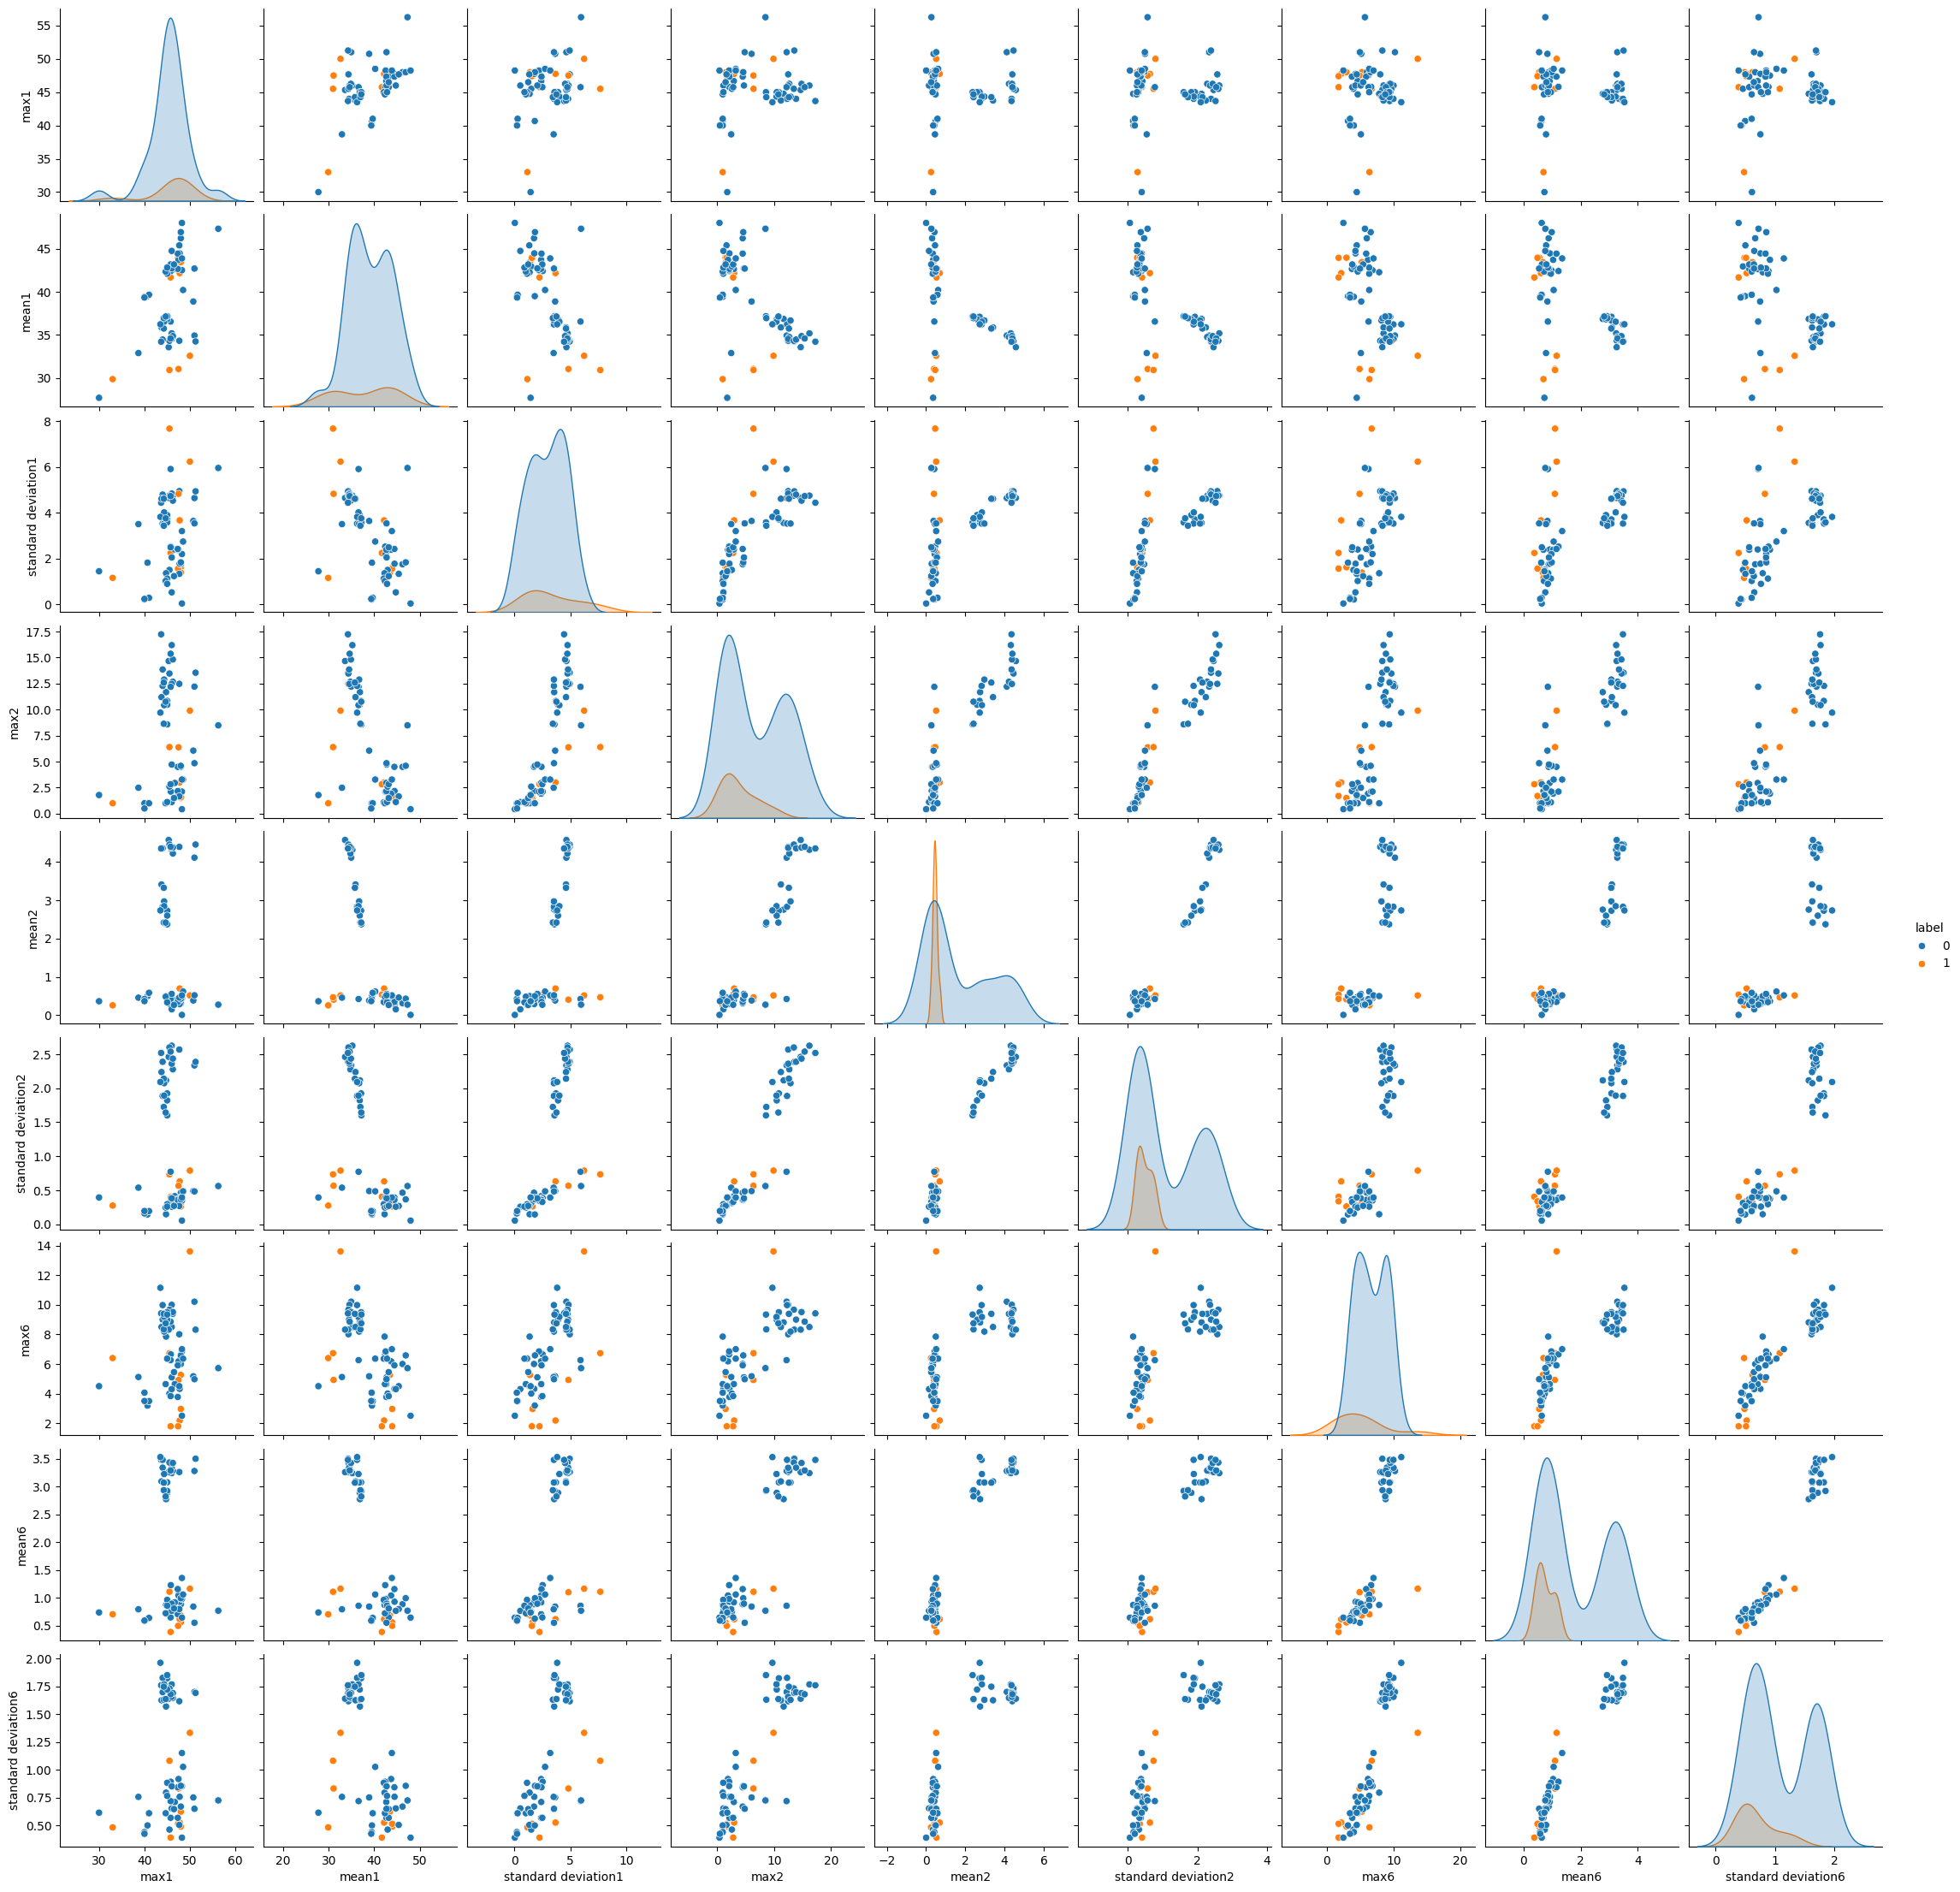

In [9]:
selected_tdf = [f"{feature}{str(ind)}" for ind in [1, 2, 6] for feature in ['max', 'mean', 'standard deviation']]
_df = _df[selected_tdf + ['label']]
sns.pairplot(_df, hue='label')
plt.show()

#### ii

In [10]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=2)
print(arr_train.shape)

_df = df_generator(arr_train, labels_train)
_df.loc[_df['label'].isin(['bending1', 'bending2']), 'label'] = 1
_df.loc[_df['label'] != 1, 'label'] = 0

(69, 84)


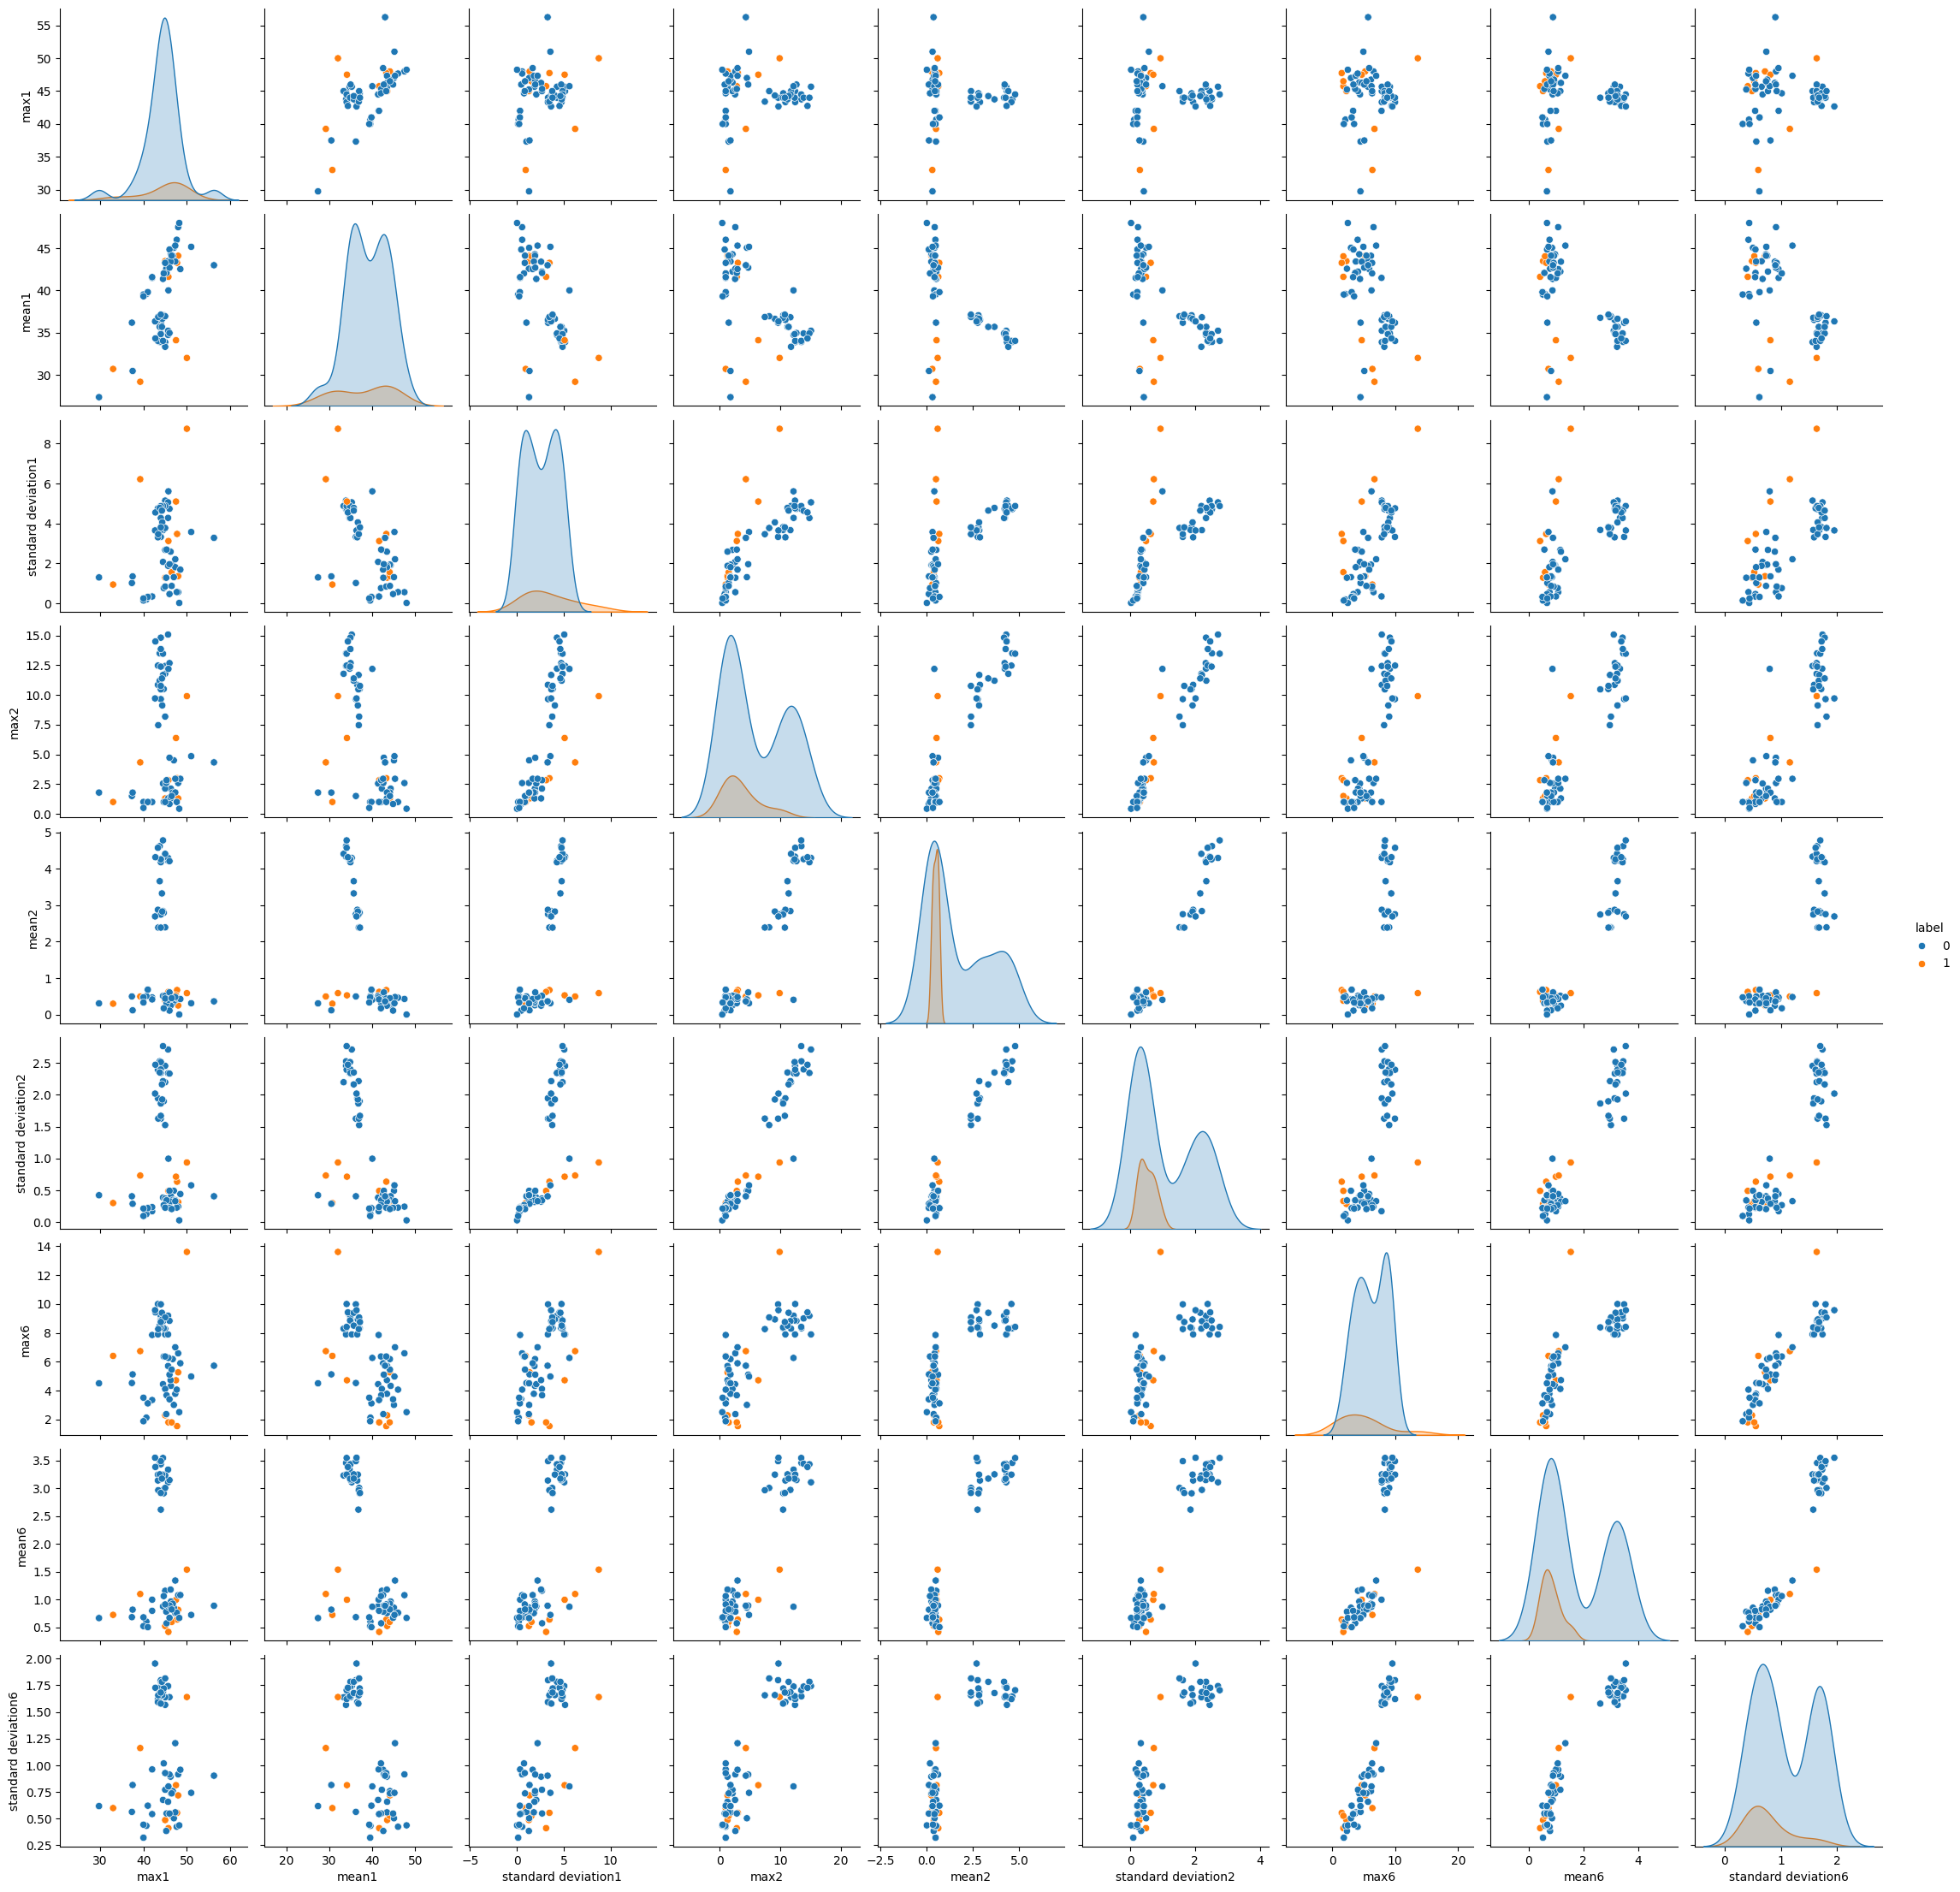

In [11]:
selected_tdf = [f"{feature}{str(ind)}" for ind in [1, 2, 6] for feature in ['max', 'mean', 'standard deviation']]
_df = _df[selected_tdf + ['label']]
sns.pairplot(_df, hue='label')
plt.show()

There is slighty difference between two scatter plots, but not a considerable difference.

#### iiii

In [12]:
def logistic_regression_fit(scoring = "accuracy", folds = 5, length = 20):
    best_score_overall = 0
    selected_features = None
    
    for L in range(1, length+1):
        arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=L)

        labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
        labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]            

        cv = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 42)
        model = LogisticRegression(penalty = None, max_iter=1000)
        selector = RFECV(estimator = model, step=1, cv = cv, scoring = scoring)
        selector.fit(arr_train, labels_train_b)
        P = selector.n_features_
        best_score = round(max(selector.cv_results_['mean_test_score']), 5)

        print(f"best pair: ({L}, {P}), {scoring}: {best_score}")

        # print(f"{best_score} {best_score_overall}")
        # print(bool(best_score > best_score_overall))
        if best_score > best_score_overall:
            best_score_overall = best_score
            selected_features = selector.support_.nonzero()[0]
    return selected_features

selected_features = logistic_regression_fit(scoring = "accuracy", folds = 5, length = 20)

best pair: (1, 7), accuracy: 1.0
best pair: (2, 2), accuracy: 0.97143
best pair: (3, 9), accuracy: 0.98571
best pair: (4, 12), accuracy: 0.98571
best pair: (5, 4), accuracy: 0.97143
best pair: (6, 13), accuracy: 0.98571
best pair: (7, 36), accuracy: 0.97143
best pair: (8, 33), accuracy: 0.98571
best pair: (9, 38), accuracy: 0.98571
best pair: (10, 45), accuracy: 0.97143
best pair: (11, 6), accuracy: 1.0
best pair: (12, 9), accuracy: 1.0
best pair: (13, 12), accuracy: 0.98571
best pair: (14, 8), accuracy: 1.0
best pair: (15, 13), accuracy: 1.0
best pair: (16, 10), accuracy: 1.0
best pair: (17, 11), accuracy: 1.0
best pair: (18, 11), accuracy: 1.0
best pair: (19, 7), accuracy: 1.0
best pair: (20, 4), accuracy: 1.0


In [13]:
# logistic_regression_fit(scoring = "accuracy", folds = 5, length = 20)
# model = LogisticRegression(penalty = None, max_iter=1000)


#### iv

seleted features: Index(['mean1', '3rd quart1', 'max2', 'min5', 'max5', 'mean5', '1st quart5'], dtype='object')
Confusion Matrix:
[[60  0]
 [ 0  9]]


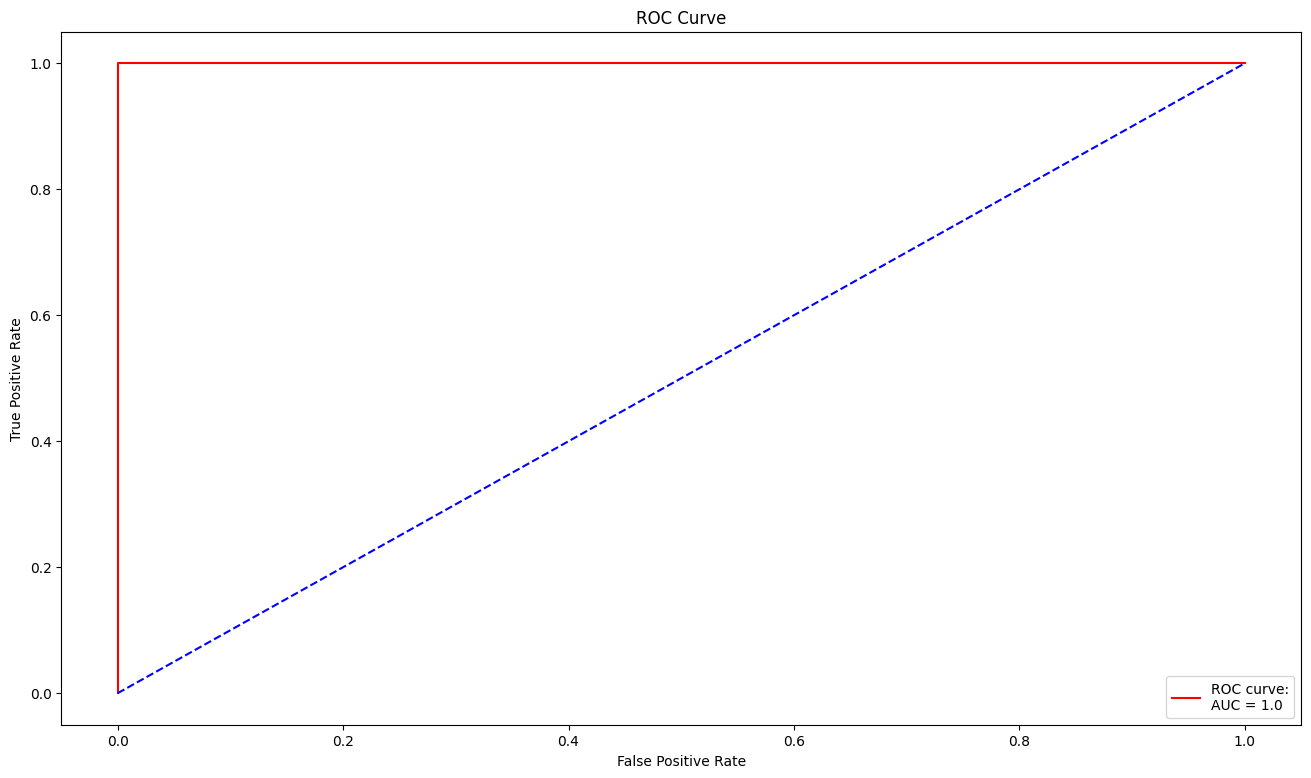

In [14]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]

_df = df_generator(arr_train, labels_train)
print(f"seleted features: {_df.columns[selected_features]}")

model = LogisticRegression(penalty = None, max_iter=1000)
model.fit(_df.iloc[:, selected_features].to_numpy(), labels_train_b)

y_train_pred = model.predict(_df.iloc[:, selected_features].to_numpy())
cm = confusion_matrix(labels_train_b, y_train_pred)
print(f"Confusion Matrix:\n{cm}")

# y_train_pred_prob = model.predict_proba(_df.iloc[:, selected_features].to_numpy())[:, 1]

fpr, tpr, thresholds = roc_curve(labels_train_b, y_train_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, color='red', label=f'ROC curve:\nAUC = {roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.title('ROC Curve')
plt.show()


In [15]:
_df.iloc[:, selected_features]

,mean1,3rd quart1,max2,min5,max5,mean5,1st quart5
0,43.969125,44.67,1.50,11.33,30.75,22.103750,20.5000
1,43.454958,45.00,1.58,8.00,33.50,23.034792,22.2500
2,42.179812,45.00,3.00,20.00,38.67,33.493917,30.4575
3,41.678063,42.75,2.83,23.67,37.50,29.857083,28.4575
4,43.954500,45.00,1.70,29.00,38.50,35.588458,35.3625
...,...,...,...,...,...,...,...
64,35.752354,39.33,12.60,4.00,24.33,16.001271,14.0000
65,37.177042,40.25,8.58,7.00,25.50,19.607250,17.9500
66,36.244083,39.25,9.71,7.67,27.00,18.497146,15.7500
67,36.957458,40.25,8.64,2.00,22.25,15.989167,14.0000


In [17]:
_X_train = _df.iloc[:, selected_features].to_numpy()
_X_train_const = sm.add_constant(_X_train)
model = sm.Logit(labels_train_b, _X_train_const)
response = model.fit(maxiter=1000)
print(response.summary())


         Current function value: inf
         Iterations: 1000


LinAlgError: Singular matrix

Since Singular matrix error occurs, I tried search resources online to find the cause and the solution.  
However, I counldn't find any reliable info to solve this problem, so I use LLM to assist me understand this issue.  
Singular matrix error occurs in linear algebra operations when trying to invert a singular (non-invertible) matrix.  
This means that the matrix is linearly dependent (some columns or rows are combinations of others).  
I find out there are several ways to solve this issue:
- Using regularization
- Adding litte bit noise into training data, to make the matrix invertible, break linear correlative structure
- Pseudo-Inverse, however it's little bit complicate to adjust statsmodels.

Since regularization is banned and Pseudo-Inverse is hard to implement, I decide to add noise into data.

In [18]:
_X_train = _df.iloc[:, selected_features].to_numpy()
# add little noise to solve Singular matrix issue
_X_train = + np.random.normal(0, 1e-10, _X_train.shape) 
_X_train_const = sm.add_constant(_X_train)
model = sm.Logit(labels_train_b, _X_train_const)
response = model.fit(maxiter=1000)
print(response.summary())


         Current function value: 0.387212
         Iterations: 1000
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:              -4.209e-09
Time:                        17:01:06   Log-Likelihood:                -26.718
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8971      0.366     -5.179      0.000      -2.615      -1.179
x1            85.9889   3.64e+09   2.36e-08      1.000   -7.14e

#### v

seleted features: Index(['mean1', '3rd quart1', 'max2', 'min5', 'max5', 'mean5', '1st quart5'], dtype='object')
Confusion Matrix:
[[15  0]
 [ 0  4]]


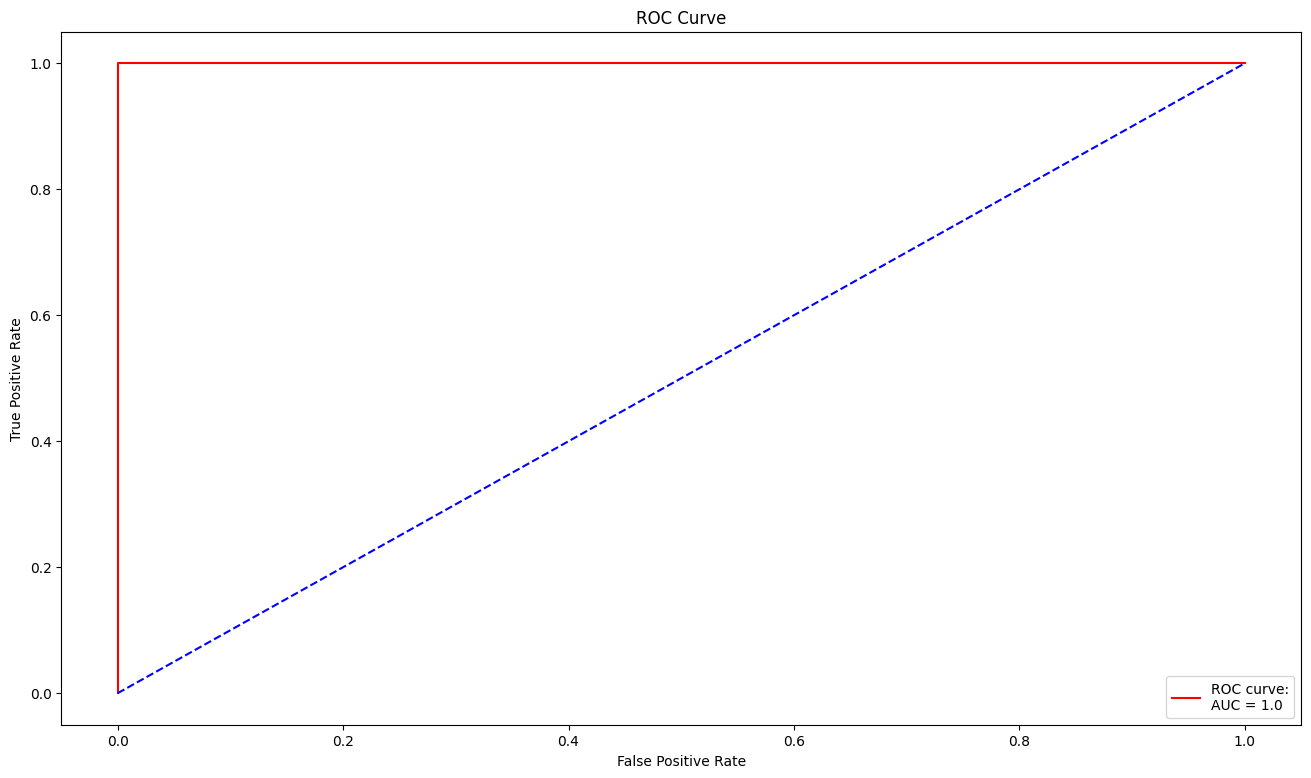

In [ ]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]

_df_train = df_generator(arr_train, labels_train)
_df_test = df_generator(arr_test, labels_test)

print(f"seleted features: {_df_train.columns[selected_features]}")

model = LogisticRegression(penalty = None, max_iter=1000)
model.fit(_df_train.iloc[:, selected_features].to_numpy(), labels_train_b)

y_pred = model.predict(_df_test.iloc[:, selected_features].to_numpy())

cm = confusion_matrix(labels_test_b, y_pred)
print(f"Confusion Matrix:\n{cm}")

# y_pred_prob = model.predict_proba(_df_test.iloc[:, selected_features].to_numpy())[:, 1]

fpr, tpr, thresholds = roc_curve(labels_test_b, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, color='red', label=f'ROC curve:\nAUC = {roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.title('ROC Curve')
plt.show()


Base on the ROC curves, both the cross-validation accuracy and the test set accuracy reach 100 percent.

#### vi  
Yes, since the logistic regression of statsmodels says that the Maximum number of iterations has been exceeded and Maximum Likelihood optimization failed to converge, it is clear that classes are well-separated to cause instability in calculating logistic regression parameters.

#### vii

Yes, there is imbalance classes existing in training dataset (60 : 9).

In [20]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]

_df_train = df_generator(arr_train, labels_train)
_df_train["label"] = labels_train_b

count_0 = len(_df_train.loc[_df_train['label'] == 0])
count_1 = len(_df_train.loc[_df_train['label'] == 1])
minor_count, major_count = min(count_0, count_1), max(count_0, count_1)
print(f"minor_count: {minor_count}")
print(f"major_count: {major_count}")
major_label = 1 if count_0 < count_1 else 0
minor = _df_train.loc[_df_train['label'] != major_label]
major = _df_train.loc[_df_train['label'] == major_label]
minor = resample(minor, replace=True, n_samples=max(count_0, count_1))
_df_train = pd.concat([minor, major])
_df_train = _df_train.reset_index(drop=True)
_df_train

minor_count: 9
major_count: 60


,min1,max1,mean1,median1,standard deviation1,1st quart1,3rd quart1,min2,max2,mean2,...,1st quart5,3rd quart5,min6,max6,mean6,median6,standard deviation6,1st quart6,3rd quart6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300,1
1,21.00,50.00,32.586208,33.00,6.238143,26.1875,34.50,0.0,9.90,0.516125,...,17.6700,23.5000,0.0,13.61,1.162042,0.830,1.332980,0.4700,1.3000,1
2,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,1
4,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600,0
116,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000,0
117,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175,0
118,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300,0


In [22]:
def logistic_regression_fit_and_oversample(scoring = "accuracy", folds = 5, length = 20, oversample=False, dataset = "train"):
    best_score_overall = 0
    selected_features = None

    def oversampling(arr, label):
        df = df_generator(arr, label)
        labels_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in label]
        df["label"] = labels_b
        count_0 = len(df.loc[df['label'] == 0])
        count_1 = len(df.loc[df['label'] == 1])
        minor_count, major_count = min(count_0, count_1), max(count_0, count_1)
        major_label = 1 if count_0 < count_1 else 0
        minor = df.loc[df['label'] != major_label]
        major = df.loc[df['label'] == major_label]
        minor = resample(minor, replace=True, n_samples=max(count_0, count_1))
        df = pd.concat([minor, major])
        df = df.reset_index(drop=True)
        return df


    for L in range(1, length+1):
        arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=L)

        labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
        labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]    
        
        if oversample:
            if dataset == "train":
                df_train = oversampling(arr_train, labels_train)
                arr_train = df_train.iloc[:, :-1].to_numpy()
                labels_train_b = df_train.iloc[:, -1].to_numpy()
                df_return = df_train
            else:
                df_test = oversampling(arr_test, labels_test)
                arr_test = df_test.iloc[:, :-1].to_numpy()
                labels_test_b = df_test.iloc[:, -1].to_numpy()     
                df_return = df_test  
        
        cv = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 42)
        model = LogisticRegression(penalty = None, max_iter=1000)
        selector = RFECV(estimator = model, step=1, cv = cv, scoring = scoring)

        selector.fit(arr_train, labels_train_b) if dataset == "train" else selector.fit(arr_test, labels_test_b)
            
        P = selector.n_features_
        best_score = round(max(selector.cv_results_['mean_test_score']), 5)

        print(f"best pair: ({L}, {P}), {scoring}: {best_score}")

        # print(f"{best_score} {best_score_overall}")
        # print(bool(best_score > best_score_overall))
        if best_score > best_score_overall:
            best_score_overall = best_score
            selected_features = selector.support_.nonzero()[0]
    
    return (df_train, selected_features)

df_train, selected_features = logistic_regression_fit_and_oversample(scoring = "accuracy", folds = 5, length = 20, oversample=True, dataset = "train")


best pair: (1, 7), accuracy: 1.0
best pair: (2, 9), accuracy: 0.99167
best pair: (3, 2), accuracy: 1.0
best pair: (4, 4), accuracy: 0.99167
best pair: (5, 3), accuracy: 0.99167
best pair: (6, 3), accuracy: 0.99167
best pair: (7, 6), accuracy: 0.99167
best pair: (8, 6), accuracy: 0.99167
best pair: (9, 4), accuracy: 1.0
best pair: (10, 3), accuracy: 0.99167
best pair: (11, 2), accuracy: 0.99167
best pair: (12, 5), accuracy: 1.0
best pair: (13, 4), accuracy: 1.0
best pair: (14, 9), accuracy: 1.0
best pair: (15, 4), accuracy: 0.99167
best pair: (16, 8), accuracy: 0.99167
best pair: (17, 3), accuracy: 1.0
best pair: (18, 4), accuracy: 0.99167
best pair: (19, 3), accuracy: 0.99167
best pair: (20, 2), accuracy: 0.99167


In [23]:
selected_features

array([ 2,  6,  8, 28, 29, 30, 33])

In [24]:
df_train

,min1,max1,mean1,median1,standard deviation1,1st quart1,3rd quart1,min2,max2,mean2,...,1st quart119,3rd quart119,min120,max120,mean120,median120,standard deviation120,1st quart120,3rd quart120,label
0,36.00,44.50,41.563750,42.000,2.133087,41.0000,42.5625,0.00,1.22,0.464583,...,26.6875,27.7500,0.00,1.00,0.307500,0.430,0.319514,0.0000,0.5000,1
1,40.00,45.00,43.513750,44.040,1.627673,42.1875,45.0000,0.00,0.87,0.387500,...,36.0000,36.0000,0.00,1.30,0.183333,0.000,0.338586,0.0000,0.4300,1
2,40.00,45.00,43.513750,44.040,1.627673,42.1875,45.0000,0.00,0.87,0.387500,...,36.0000,36.0000,0.00,1.30,0.183333,0.000,0.338586,0.0000,0.4300,1
3,27.00,31.25,28.309167,28.000,1.327390,27.0000,29.1250,0.00,0.87,0.129583,...,16.9375,26.4375,0.00,1.70,0.891250,0.885,0.457463,0.5000,1.1650,1
4,21.00,26.00,23.320000,23.635,1.300779,22.6875,24.0000,0.00,0.87,0.358333,...,17.6700,19.0000,0.00,1.41,0.705000,0.770,0.395606,0.4700,1.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,28.25,44.00,36.413333,35.500,4.556487,33.6275,40.0625,0.82,7.56,3.081667,...,14.9375,19.5000,0.83,7.72,2.572917,2.170,1.591976,1.5600,2.9950,0
116,30.75,43.25,36.107500,34.500,4.129581,32.7500,40.5000,0.00,6.18,2.463333,...,18.0000,21.8125,0.87,7.79,2.698750,2.470,1.651232,1.4100,3.3700,0
117,31.50,41.67,36.903333,37.000,3.325895,34.4800,39.3750,0.43,6.26,2.742083,...,17.1875,22.0625,0.47,7.76,3.099167,2.725,1.657384,2.0175,4.0125,0
118,30.00,42.50,36.631667,35.540,3.691762,34.2500,39.5000,0.43,5.26,2.561667,...,15.3100,18.3725,0.00,6.38,2.795417,2.490,1.443507,1.8525,3.5025,0


seleted features: [ 2  6  8 28 29 30 33]
Confusion Matrix:
[[60  0]
 [ 0 60]]


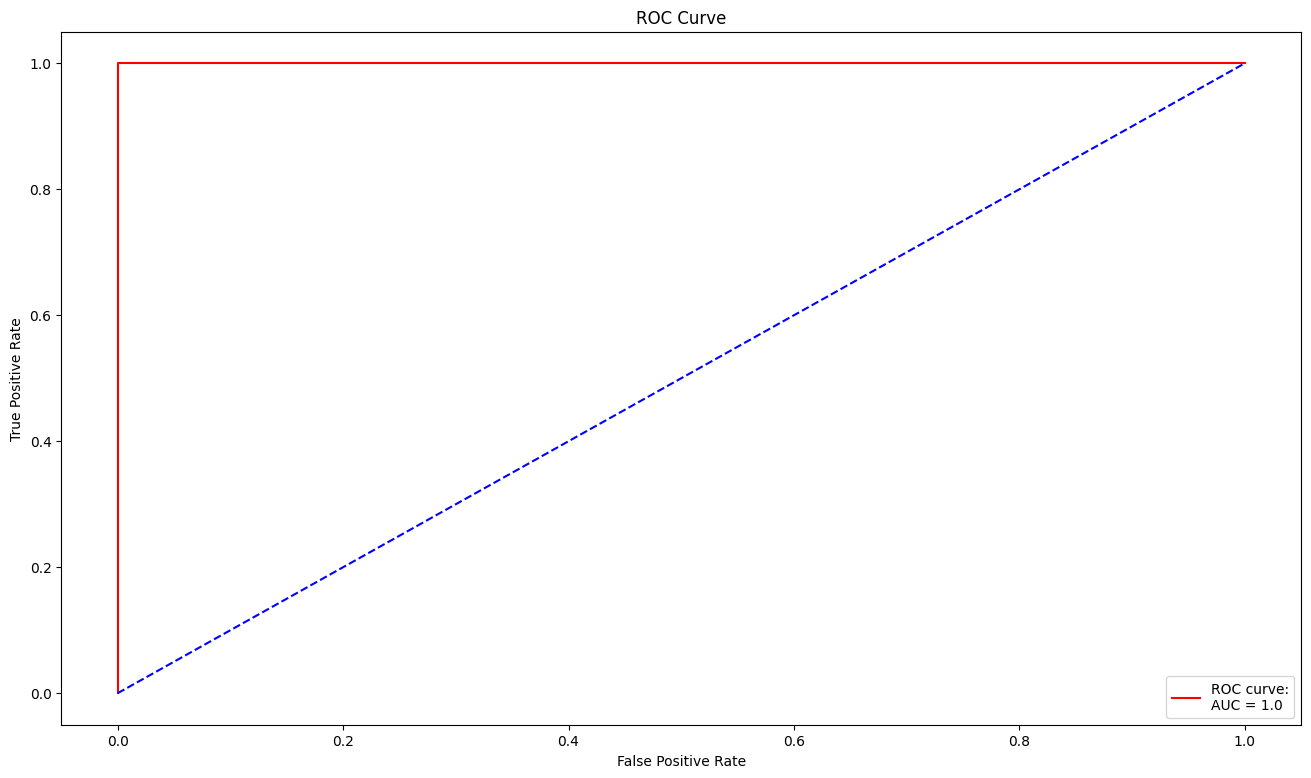

In [25]:
print(f"seleted features: {selected_features}")

model = LogisticRegression(penalty = None, max_iter=1000)
model.fit(df_train.iloc[:, selected_features].to_numpy(), df_train.iloc[:, -1])

y_pred = model.predict(df_train.iloc[:, selected_features].to_numpy())

cm = confusion_matrix(df_train.iloc[:, -1], y_pred)
print(f"Confusion Matrix:\n{cm}")

# arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
# labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
# labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]

# _df_train = df_generator(arr_train, labels_train)
# _df_test = df_generator(arr_test, labels_test)

y_train_pred_prob = model.predict_proba(df_train.iloc[:, selected_features].to_numpy())[:, 1]
fpr, tpr, thresholds = roc_curve( df_train.iloc[:, -1], y_train_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, color='red', label=f'ROC curve:\nAUC = {roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.title('ROC Curve')
plt.show()

l = 1 has the best accuracy.

Confusion Matrix:
[[14  1]
 [ 1  3]]


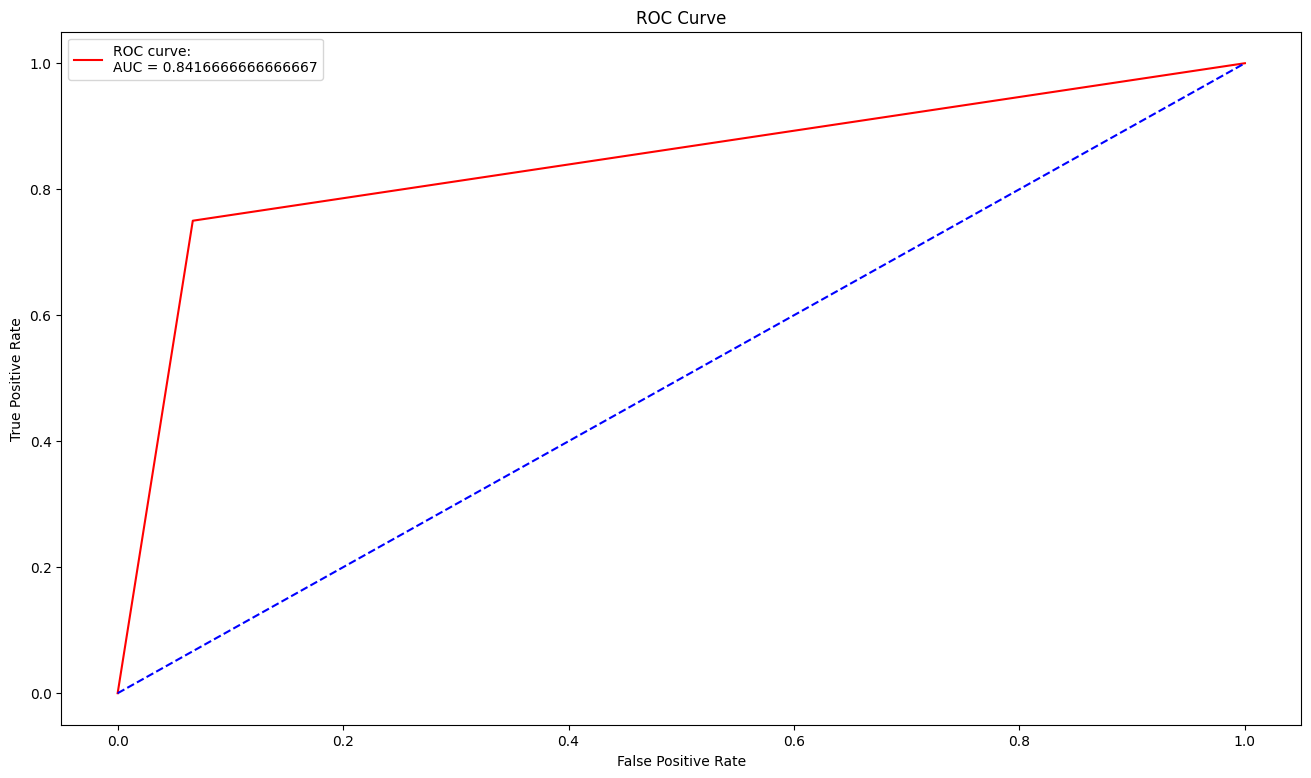

In [26]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]

df_test = df_generator(arr_test, labels_test)
df_test["label"] = labels_test_b
y_pred = model.predict(df_test.iloc[:, selected_features].to_numpy())

cm = confusion_matrix(labels_test_b, y_pred)
print(f"Confusion Matrix:\n{cm}")

y_pred_prob = model.predict_proba(df_test.iloc[:, selected_features].to_numpy())[:, 1]
fpr, tpr, thresholds = roc_curve(labels_test_b, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, color='red', label=f'ROC curve:\nAUC = {roc_auc}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.title('ROC Curve')
plt.show()

### 2.(b)

#### i

In [31]:
def logistic_regression_fit_2(scoring = "accuracy", folds = 5, length = 20, mode="binary"):
    def draw_roc(model, y, y_pred_prob, mode):
        fig, axes = plt.subplots(figsize=(16, 9))
        for i, c in enumerate(model.classes_):
            fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:, i], pos_label=c)
            roc_auc = auc(fpr, tpr)
            axes.plot(fpr, tpr, label=f"ROC Curve of {c}, area = {round(roc_auc, 5)}")
        axes.plot([0, 1], [0, 1], linestyle = "--", color = "blue")
        axes.set_title(f"Testing ROC curve for {mode}")
        axes.set_xlabel("False Positive Rate")
        axes.set_ylabel("True Positive Rate")
        axes.legend()
        plt.show()

    best_score = 0
    best_score_overall = 0
    non_zero_features = None 
    selected_features = None
    
    for L in range(1, length+1):
        arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=L)

        labels_train_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_train]
        labels_test_b = [1 if i == 'bending1' or i =='bending2' else 0 for i in labels_test]            

        cv = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 42)

        if mode == "binary":
            model = LogisticRegression(penalty = "l1", max_iter=1000, solver="liblinear")
            param_grid = {'C': [0.1, 1, 10, 100, 1000]}
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring)
            grid_search.fit(arr_train, labels_train_b)
            C =  grid_search.best_estimator_.C
            best_model = grid_search.best_estimator_
            coef = best_model.coef_[0]
            non_zero_features = np.where(coef != 0)[0]
            best_score = round(max(grid_search.cv_results_['mean_test_score']), 5)
            print(f"best pair: ({L}, {len(non_zero_features)}), C: {C}, {scoring}: {best_score}")
        elif mode == "multinomial":            
            model = LogisticRegression(penalty = "l1", max_iter=1000, solver="saga")
            param_grid = {'C': [0.1, 1, 10, 100, 1000]}
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
            grid_search.fit(arr_train, labels_train)
            C =  grid_search.best_estimator_.C
            best_model = grid_search.best_estimator_
            coef = best_model.coef_[0]
            non_zero_features = np.where(coef != 0)[0]
            best_score = grid_search.best_score_
            print(f"best pair: ({L}, {len(non_zero_features)}), C: {C}, {scoring}: {best_score}, error: {1-best_score}")

        elif mode == "GaussianNB":
            model = GaussianNB()
            score = cross_val_score(estimator = model, X = arr_train, y = labels_train, cv = cv, scoring = scoring)
            best_score = np.mean(score)
            print(f"L: {L}, {scoring}: {best_score}, error: {1-best_score}")

        elif mode == "MultinomialNB":
            model = MultinomialNB()
            score = cross_val_score(estimator = model, X = arr_train, y = labels_train, cv = cv, scoring = scoring)
            best_score = np.mean(score)
            print(f"L: {L}, {scoring}: {best_score}, error: {1-best_score}")

        if best_score > best_score_overall:
            best_score_overall = best_score
            selected_features = non_zero_features
    return selected_features

In [32]:
selected_features = logistic_regression_fit_2(scoring = "accuracy", folds = 5, length = 20,  mode="binary")

best pair: (1, 7), C: 1, accuracy: 1.0
best pair: (2, 11), C: 1, accuracy: 0.98571
best pair: (3, 12), C: 1, accuracy: 0.95714
best pair: (4, 14), C: 1, accuracy: 0.97143
best pair: (5, 9), C: 0.1, accuracy: 0.92857
best pair: (6, 16), C: 1, accuracy: 0.95714
best pair: (7, 105), C: 100, accuracy: 0.95714
best pair: (8, 18), C: 1, accuracy: 0.95714
best pair: (9, 8), C: 0.1, accuracy: 0.94286
best pair: (10, 159), C: 100, accuracy: 0.95714
best pair: (11, 6), C: 0.1, accuracy: 0.95714
best pair: (12, 6), C: 0.1, accuracy: 0.95714
best pair: (13, 11), C: 1, accuracy: 0.95714
best pair: (14, 14), C: 1, accuracy: 0.95714
best pair: (15, 135), C: 100, accuracy: 0.94286
best pair: (16, 70), C: 10, accuracy: 0.95714
best pair: (17, 26), C: 1, accuracy: 0.95714
best pair: (18, 24), C: 1, accuracy: 0.97143
best pair: (19, 25), C: 1, accuracy: 0.97143
best pair: (20, 31), C: 1, accuracy: 1.0


#### ii

Compare these two methods, it seems that they all perform well.  
Although the logistic regression using p-value has overall higer f1 among different time series length data, both of model achieve 100% accuracy when l = 1, so I think these two methods are good.

For implementation, it's obvious that using l1-penalized is much more easier, since we only have to set hyperparameter and sklearn will handle everything for us.
 

### 2.(c)

#### i

In [33]:
selected_features = logistic_regression_fit_2(scoring = "accuracy", folds = 5, length = 20,  mode="multinomial")


best pair: (1, 13), C: 1, accuracy: 0.9131868131868132, error: 0.08681318681318684
best pair: (2, 76), C: 10, accuracy: 0.8406593406593406, error: 0.15934065934065944
best pair: (3, 114), C: 10, accuracy: 0.7835164835164835, error: 0.2164835164835165
best pair: (4, 149), C: 10, accuracy: 0.8120879120879121, error: 0.1879120879120879
best pair: (5, 68), C: 1, accuracy: 0.8263736263736264, error: 0.17362637362637356
best pair: (6, 77), C: 1, accuracy: 0.8263736263736263, error: 0.17362637362637368
best pair: (7, 290), C: 100, accuracy: 0.767032967032967, error: 0.23296703296703303
best pair: (8, 295), C: 10, accuracy: 0.7824175824175824, error: 0.2175824175824176
best pair: (9, 329), C: 10, accuracy: 0.7967032967032966, error: 0.20329670329670335
best pair: (10, 372), C: 10, accuracy: 0.767032967032967, error: 0.23296703296703303
best pair: (11, 461), C: 100, accuracy: 0.7813186813186812, error: 0.2186813186813188
best pair: (12, 443), C: 10, accuracy: 0.7956043956043957, error: 0.204395

l = 1 has the best accuracy.

In [34]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)

model = LogisticRegression(penalty = "l1", max_iter=1000, solver="saga")
model.fit(arr_train, labels_train)

y_train_pred_prob = model.predict_proba(arr_train)
y_pred_prob = model.predict_proba(arr_test)

y_pred = model.predict(arr_test)
cm = confusion_matrix(labels_test, y_pred)
print(cm)

[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


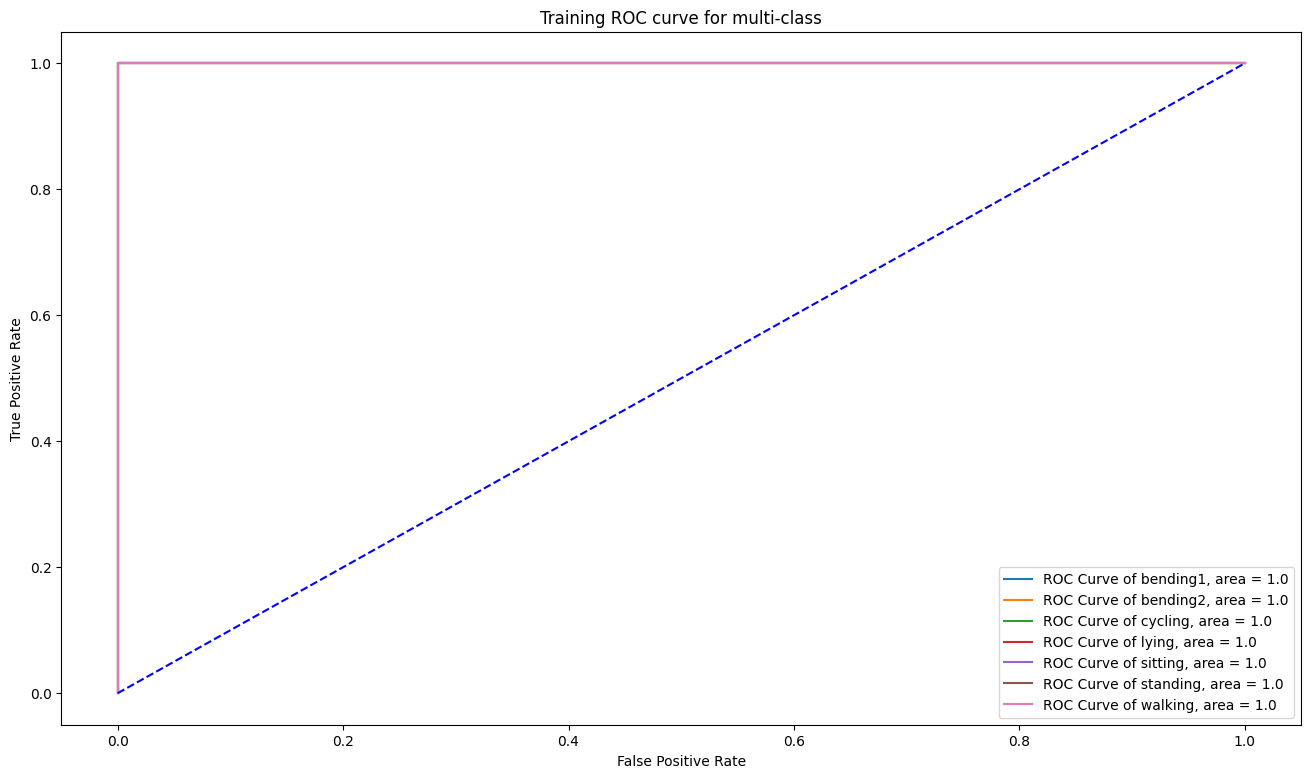

In [35]:
fig, axes = plt.subplots(figsize=(16, 9))
for i, c in enumerate(model.classes_):
    fpr, tpr, thresholds = roc_curve(labels_train, y_train_pred_prob[:, i], pos_label=c)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label=f"ROC Curve of {c}, area = {round(roc_auc, 5)}")
axes.plot([0, 1], [0, 1], linestyle = "--", color = "blue")
axes.set_title(f"Training ROC curve for multi-class")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
plt.show()

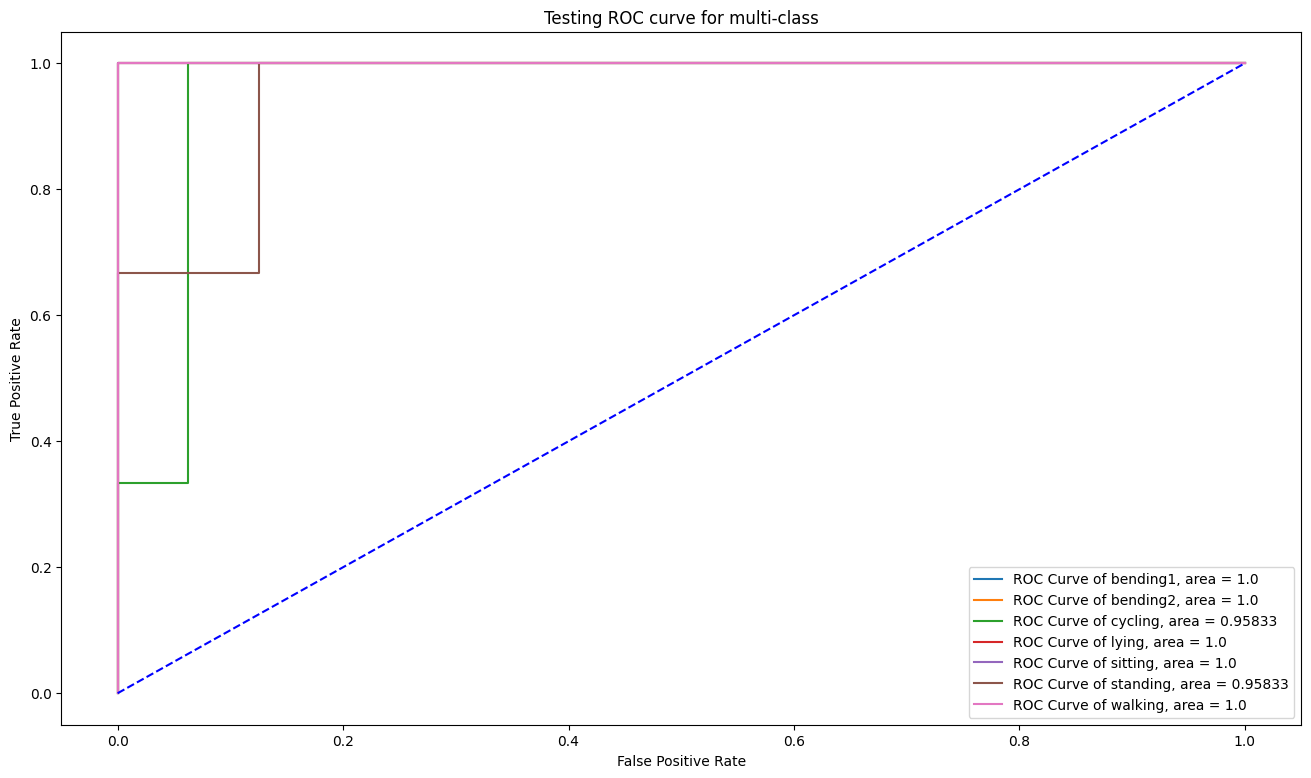

In [36]:
fig, axes = plt.subplots(figsize=(16, 9))
for i, c in enumerate(model.classes_):
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob[:, i], pos_label=c)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label=f"ROC Curve of {c}, area = {round(roc_auc, 5)}")
axes.plot([0, 1], [0, 1], linestyle = "--", color = "blue")
axes.set_title(f"Testing ROC curve for multi-class")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
plt.show()

#### ii

In [37]:
def draw_roc(model, y, y_pred_prob, mode):
    fig, axes = plt.subplots(figsize=(16, 9))
    for i, c in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:, i], pos_label=c)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"ROC Curve of {c}, area = {round(roc_auc, 5)}")
    axes.plot([0, 1], [0, 1], linestyle = "--", color = "blue")
    axes.set_title(f"Testing ROC curve for {mode}")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [38]:
logistic_regression_fit_2(scoring = "accuracy", folds = 5, length = 20, mode="GaussianNB")

L: 1, accuracy: 0.8406593406593407, error: 0.15934065934065933
L: 2, accuracy: 0.8120879120879121, error: 0.1879120879120879
L: 3, accuracy: 0.7516483516483516, error: 0.24835164835164836
L: 4, accuracy: 0.6648351648351649, error: 0.3351648351648351
L: 5, accuracy: 0.6494505494505495, error: 0.3505494505494505
L: 6, accuracy: 0.6648351648351648, error: 0.3351648351648352
L: 7, accuracy: 0.6802197802197802, error: 0.31978021978021975
L: 8, accuracy: 0.6945054945054945, error: 0.3054945054945055
L: 9, accuracy: 0.621978021978022, error: 0.378021978021978
L: 10, accuracy: 0.6637362637362637, error: 0.3362637362637363
L: 11, accuracy: 0.6362637362637362, error: 0.3637362637362638
L: 12, accuracy: 0.5945054945054944, error: 0.4054945054945056
L: 13, accuracy: 0.665934065934066, error: 0.334065934065934
L: 14, accuracy: 0.6362637362637363, error: 0.36373626373626367
L: 15, accuracy: 0.5802197802197802, error: 0.41978021978021984
L: 16, accuracy: 0.5648351648351648, error: 0.4351648351648352


Test Accuracy: 0.8947368421052632
Test Error: 0.10526315789473684
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


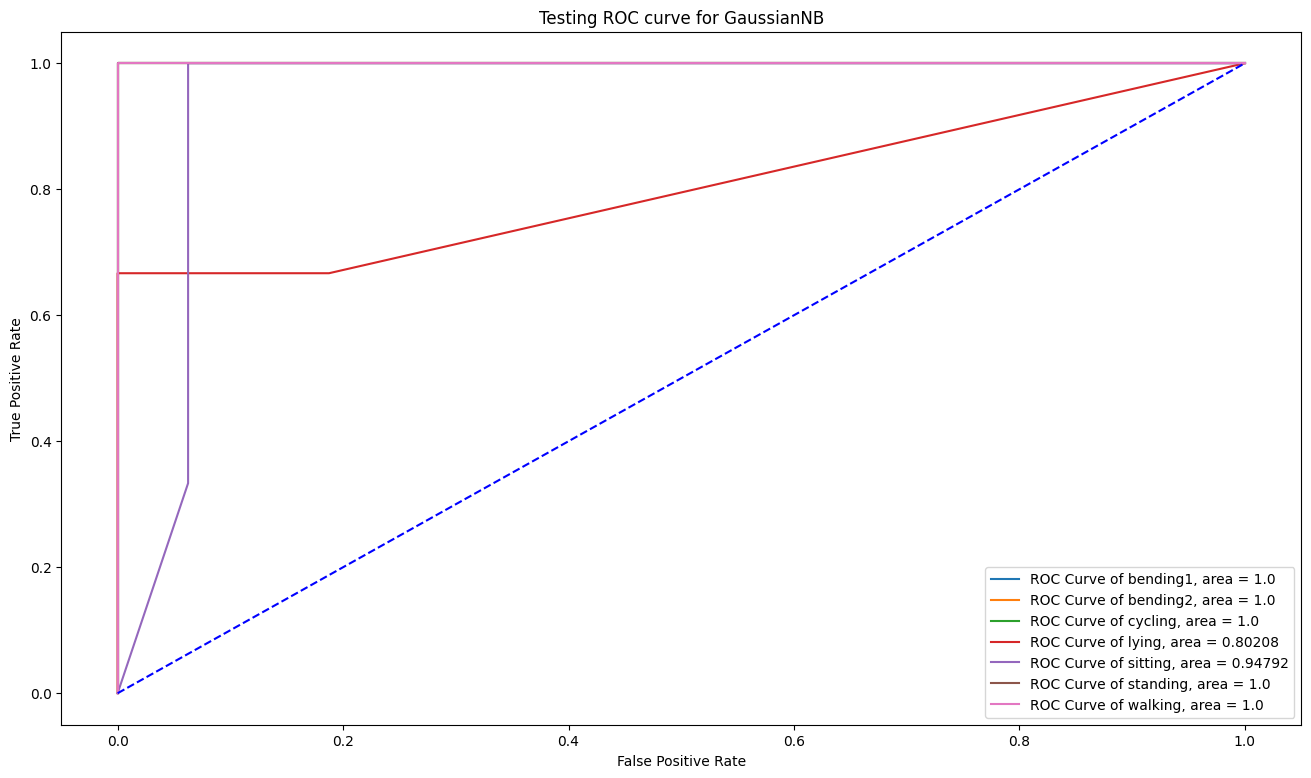

In [39]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
model = GaussianNB()
model.fit(arr_train, labels_train)
y_pred = model.predict(arr_test)
print(f"Test Accuracy: {model.score(arr_test, labels_test)}")
print(f"Test Error: {1 - model.score(arr_test, labels_test)}")

cm = confusion_matrix(labels_test, y_pred)
print(cm)

y_pred_prob = model.predict_proba(arr_test)
draw_roc(model, labels_test, y_pred_prob, "GaussianNB")



In [40]:
logistic_regression_fit_2(scoring = "accuracy", folds = 5, length = 20, mode="MultinomialNB")

L: 1, accuracy: 0.8549450549450549, error: 0.1450549450549451
L: 2, accuracy: 0.7648351648351648, error: 0.23516483516483522
L: 3, accuracy: 0.7802197802197802, error: 0.21978021978021978
L: 4, accuracy: 0.7956043956043957, error: 0.20439560439560434
L: 5, accuracy: 0.8252747252747253, error: 0.17472527472527466
L: 6, accuracy: 0.7813186813186814, error: 0.21868131868131857
L: 7, accuracy: 0.7813186813186812, error: 0.2186813186813188
L: 8, accuracy: 0.7945054945054946, error: 0.20549450549450543
L: 9, accuracy: 0.767032967032967, error: 0.23296703296703303
L: 10, accuracy: 0.7824175824175824, error: 0.2175824175824176
L: 11, accuracy: 0.7527472527472527, error: 0.24725274725274726
L: 12, accuracy: 0.7516483516483516, error: 0.24835164835164836
L: 13, accuracy: 0.7516483516483516, error: 0.24835164835164836
L: 14, accuracy: 0.7373626373626373, error: 0.2626373626373627
L: 15, accuracy: 0.765934065934066, error: 0.234065934065934
L: 16, accuracy: 0.7516483516483516, error: 0.24835164835

Test Accuracy: 0.8947368421052632
Test Error: 0.10526315789473684
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


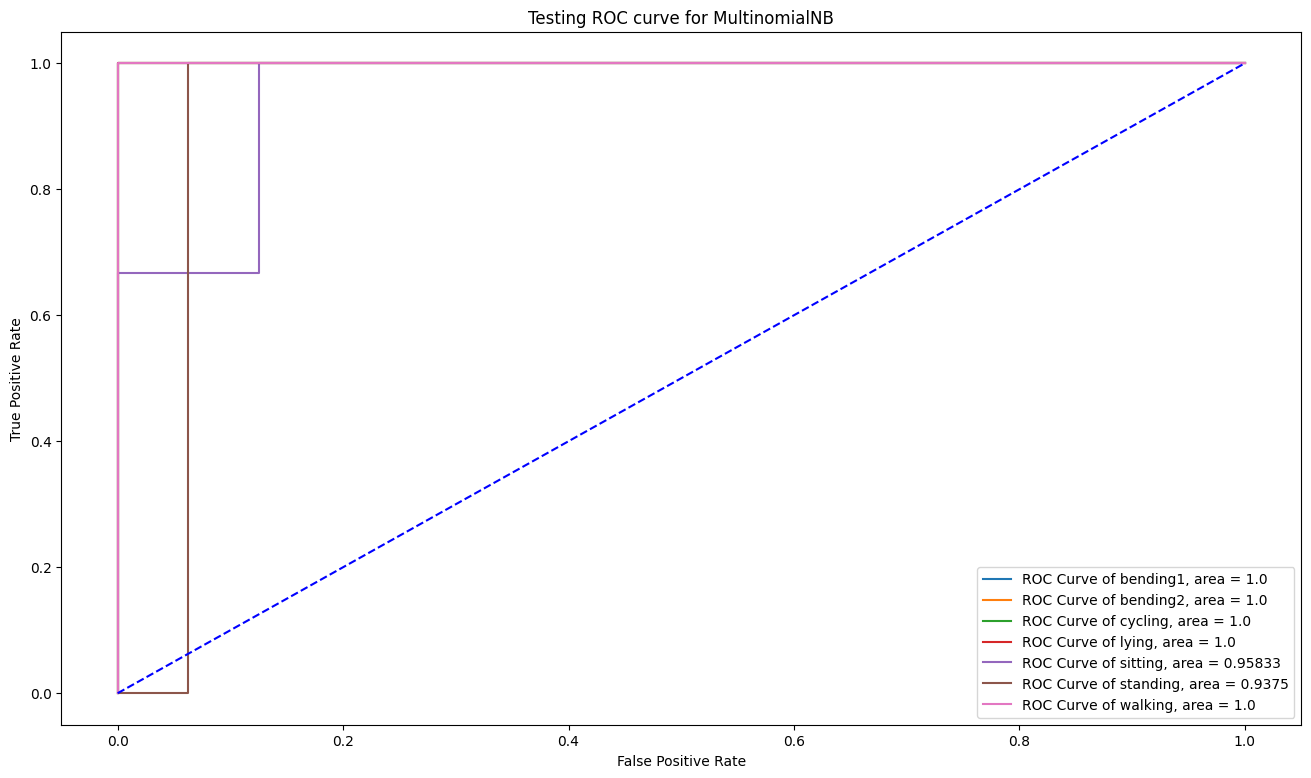

In [41]:
arr_train, arr_test, labels_train, labels_test = process_data(data_path = "../data/AReM", seg=1)
model = MultinomialNB()
model.fit(arr_train, labels_train)
y_pred = model.predict(arr_test)
print(f"Test Accuracy: {model.score(arr_test, labels_test)}")
print(f"Test Error: {1 - model.score(arr_test, labels_test)}")

cm = confusion_matrix(labels_test, y_pred)
print(cm)

y_pred_prob = model.predict_proba(arr_test)
draw_roc(model, labels_test, y_pred_prob, "MultinomialNB")

#### iii

According to above results, Naive Bayes’ classifier of Multi-nomial priors performs best in the problem.

### 3. ISLR 4.8.3

<img src="../pic/S__1204227_0.jpg">

<img src="../pic/S__1204229_0.jpg">

### 4. ISLR 4.8.7

<img src="../pic/69405608-16DA-4FD7-8676-3F8A0A61D23C.jpg">


<img src="../pic/S__1204231_0.jpg">